# Generate Amazon Reviews Dataset

In this notebook, we:
1. Download the WILDS Amazon Reviews benchmark dataset.
2. Use a subset of 20,000 to fine-tune a BERT model with the empirical risk minimization objective.
3. Apply the network to held-out training set of 2,000 examples from source and target domain each. Apply the netwrok to a validation sets of size 2,000 examples from taregt domain.
4. Use the penultimate layer of the network outputs to generate frozen feature representations of the train and validation set.

The step requires the use of a GPU to run efficiently, listed as the `DEVICE` parameter below. 


In [1]:
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader
from wilds.common.grouper import CombinatorialGrouper
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import torch
from tqdm import tqdm
import datetime
import time
import random
import pickle
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib.patches import Patch
from matplotlib.colors import Normalize, to_rgba

from transformers import AutoTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset
from sklearn.preprocessing import LabelEncoder


## Fine-Tune BERT Model

We first create the fine-tuning set to use on the pre-trained BERT architecture. This involves downloading, splitting, and tokenizing the text.

In [2]:
LEARNING_RATE = 2e-5
ADAMW_TOLERANCE = 1e-8
BATCH_SIZE = 32
EPOCHS = 2
SEED = 123
FILENAME = "bert_amazon_finetuned"
DEVICE = 0

In [3]:
if torch.cuda.is_available():
    device = f"cuda:{DEVICE}"
else:
    device = "cpu"
print("Running on '%s'." % device)

Running on 'cuda:0'.


The dataset download takes (on the order of) 10 minutes.

In [4]:
# Load the full dataset, and download it if necessary.
dataset = get_dataset(dataset="amazon", download=True)

In [5]:
print(dataset.metadata_fields)
all_categories = dataset.metadata_map['category']
label_encoder1 = LabelEncoder()
label_encoder1.fit(all_categories)
print(pd.DataFrame({'category': list(label_encoder1.classes_), 'label': label_encoder1.transform(label_encoder1.classes_)}))
grouper = CombinatorialGrouper(dataset, ['category'])

['user', 'product', 'category', 'year', 'y', 'from_source_domain']
                       category  label
0                    All_Beauty      0
1        Arts_Crafts_and_Sewing      1
2                    Automotive      2
3                         Books      3
4                 CDs_and_Vinyl      4
5   Cell_Phones_and_Accessories      5
6    Clothing_Shoes_and_Jewelry      6
7                 Digital_Music      7
8                   Electronics      8
9                    Gift_Cards      9
10     Grocery_and_Gourmet_Food     10
11             Home_and_Kitchen     11
12    Industrial_and_Scientific     12
13                 Kindle_Store     13
14                Luxury_Beauty     14
15       Magazine_Subscriptions     15
16                Movies_and_TV     16
17          Musical_Instruments     17
18              Office_Products     18
19        Patio_Lawn_and_Garden     19
20                 Pet_Supplies     20
21                 Prime_Pantry     21
22                     Software     

In [6]:
print(f'Out of {len(dataset)} total data points, there are a total of {len(np.where(dataset[:][2][:,2] == 2)[0])} reviews from Books and {len(np.where(dataset[:][2][:,2] == 6)[0])} from Home and Kithcen.')

Out of 4002170 total data points, there are a total of 2779625 reviews from Books and 126421 from Home and Kithcen.


In [7]:
n = 7500

idx1 = np.random.choice(np.where(dataset[:][2][:,2] == 2)[0], n)
idx2 = np.random.choice(np.where(dataset[:][2][:,2] == 6)[0], n)

print(len(idx1), len(idx2))

source_dataset = Subset(dataset, idx1)
target_dataset = Subset(dataset, idx2)


7500 7500


In [8]:
source_dataset[2]

("This book was very interesting to say the least.  I'm sorry but I just think Kai was just to darn dingy.  There is no way she should have started that love triangle with her mans best friend and she had to be blind as hell not to see that at some point Todd and Alana had something more than a regular friendship no matter what they told her.  All and all I still gave the book four stars but I must say this book was VERY predictable.  I wasn't surprised at all with what her brother revealed to her or anything.",
 tensor(3),
 tensor([23865, 85403,     2,    16,     3,     0]))

In [9]:
target_dataset[2]

('Great quality and no smell. We put it down on the bed and slept on it the following night. Made a HUGE difference in comfort. No issues with the packaging or getting it unraveled. It was slightly too long for our twin bed, so we cut off the end with a scissor.',
 tensor(4),
 tensor([ 2322, 10969,     6,    21,     4,     0]))

In [10]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [11]:
def get_split(split, n, tokenizer, grouper):
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attn_masks = []
    labels = []
    groups = []

    # For every sentence...
    # sentences = dataset[split]["text"]
    # train_data = dataset.get_subset(split)
    
    loader = get_train_loader("standard", dataset.get_subset(split), batch_size=1)
    # if split != "train":
    #     idx = np.arange(len(sentences))
    
    for i, (x, y, z) in tqdm(enumerate(loader)):

        encoded_dict = tokenizer.encode_plus(
            x[0],  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=80,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask = True,   # Construct attn. masks.
            return_tensors="pt",  # Return pytorch tensors.
        )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict["input_ids"])
        attn_masks.append(encoded_dict["attention_mask"])
        labels.append(1 if y.item() >= 4 else 0)
        groups.append(grouper.metadata_to_group(z))

        if i == n - 1:
            break

    input_ids = torch.cat(input_ids, dim=0)
    attn_masks = torch.cat(attn_masks, dim=0)
    labels = torch.tensor(labels).long()
    groups = torch.cat(groups)

    return input_ids, attn_masks, labels, groups

class Amazon(Dataset):
    def __init__(self, input_ids, attn_masks, labels, groups):
        self.input_ids = input_ids
        self.attn_masks = attn_masks
        self.labels = labels
        self.groups = groups

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, i):
        return self.input_ids[i], self.attn_masks[i], self.labels[i], self.groups[i]

Create dataloaders for the non-convex training set (`train`) and convex training set (`finetune`) set.

In [ ]:
# Create dataloaders.
np.random.seed(123)

# train dataset
train_dataset = Amazon(*get_split('train', 20000, tokenizer, grouper))
train_dataloader = DataLoader(
    train_dataset, sampler=RandomSampler(train_dataset), batch_size=BATCH_SIZE
)
print("{:>5,} training samples.".format(len(train_dataset)))

# val dataset
val_dataset = Amazon(*get_split("val", 20000, tokenizer, grouper))
validation_dataloader = DataLoader(
    val_dataset, sampler=SequentialSampler(val_dataset), batch_size=BATCH_SIZE
)
print("{:>5,} validation samples.".format(len(val_dataset)))

# test dataset
test_dataset = Amazon(*get_split("test", 20000, tokenizer, grouper))
test_dataloader = DataLoader(
    test_dataset, sampler=RandomSampler(test_dataset), batch_size=BATCH_SIZE
)
print("{:>5,} test samples.".format(len(test_dataset)))

## Train Model 

We run the standard training loop for `N_EPOCHS` epochs.

In [13]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=5,
    output_attentions=False,
    output_hidden_states=True,
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
# utility functions
def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [55]:
optimizer = AdamW(model.parameters(), lr = LEARNING_RATE, eps = ADAMW_TOLERANCE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = EPOCHS * BATCH_SIZE * len(train_dataloader))

/home/medhaaga/miniconda3/envs/wildlife/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


The full training loop is run below.

In [16]:
# Seed everything.
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

training_stats = []
total_t0 = time.time()
for epoch_i in range(EPOCHS):

    # ========================================
    #               Training
    # ========================================

    print("")
    print("======== Epoch {:} / {:} ========".format(epoch_i + 1, EPOCHS))
    print("Training...")

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 100 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(
                "  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.".format(
                    step, len(train_dataloader), elapsed
                )
            )

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        output = model(
            b_input_ids,
            attention_mask=b_input_mask,
            labels=b_labels,
            return_dict=True,
        )

        loss = output.loss
        logits = output.logits
        

        total_train_loss += loss.item()

        loss.backward()

        # TODO: See if this is needed.
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            output = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )
            loss = output.loss
            logits = output.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            "epoch": epoch_i + 1,
            "Training Loss": avg_train_loss,
            "Valid. Loss": avg_val_loss,
            "Valid. Accur.": avg_val_accuracy,
            "Training Time": training_time,
            "Validation Time": validation_time,
        }
    )

print("")
print("Training complete!")

print(
    "Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_t0))
)

# Save the model.
torch.save(model, f"{FILENAME}.pt")
pickle.dump(
    training_stats, open(f"training_stats_{FILENAME}.p", "wb")
)


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    625.    Elapsed: 0:00:15.
  Batch    80  of    625.    Elapsed: 0:00:30.
  Batch   120  of    625.    Elapsed: 0:00:45.
  Batch   160  of    625.    Elapsed: 0:01:00.
  Batch   200  of    625.    Elapsed: 0:01:16.
  Batch   240  of    625.    Elapsed: 0:01:31.
  Batch   280  of    625.    Elapsed: 0:01:46.
  Batch   320  of    625.    Elapsed: 0:02:01.
  Batch   360  of    625.    Elapsed: 0:02:16.
  Batch   400  of    625.    Elapsed: 0:02:31.
  Batch   440  of    625.    Elapsed: 0:02:46.
  Batch   480  of    625.    Elapsed: 0:03:01.
  Batch   520  of    625.    Elapsed: 0:03:16.
  Batch   560  of    625.    Elapsed: 0:03:31.
  Batch   600  of    625.    Elapsed: 0:03:46.

  Average training loss: 0.59
  Training epcoh took: 0:03:55

Running Validation...
  Accuracy: 0.72
  Validation Loss: 0.55
  Validation took: 0:01:14

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    625.    Elapsed: 0:00:15.
  Batch  

In [13]:
with open(f"training_stats_{FILENAME}.p", 'rb') as f:
    # Load the object from the file
    training_stats = pickle.load(f)

training_stats

[{'epoch': 1,
  'Training Loss': 0.5869916233539582,
  'Valid. Loss': 0.5463704987287521,
  'Valid. Accur.': 0.71885,
  'Training Time': '0:03:55',
  'Validation Time': '0:01:14'},
 {'epoch': 2,
  'Training Loss': 0.4421356351852417,
  'Valid. Loss': 0.5786447491168976,
  'Valid. Accur.': 0.74195,
  'Training Time': '0:03:55',
  'Validation Time': '0:01:14'}]

In [14]:
def get_hidden_states(dataloader):
    model.eval()
    hidden_states = []
    labels = []
    groups = []
    for batch in tqdm(dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_groups = batch[3]
        with torch.no_grad():
            output = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )
            hidden_states.append(torch.mean(output.hidden_states[-1], dim=1))
            labels.append(b_labels)
            groups.append(b_groups)
    return torch.cat(hidden_states, dim=0).cpu().numpy(), torch.cat(labels, dim=0).cpu().numpy(), torch.cat(groups, dim=0).cpu().numpy()

In [15]:
def tokenize_loader(loader, tokenizer, grouper):

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attn_masks = []
    labels = []
    groups = []

    
    for i, (x, y, z) in tqdm(enumerate(loader)):

        encoded_dict = tokenizer.encode_plus(
            x[0],  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=80,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask = True,   # Construct attn. masks.
            return_tensors="pt",  # Return pytorch tensors.
        )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict["input_ids"])
        attn_masks.append(encoded_dict["attention_mask"])
        labels.append(1 if y.item() >= 4 else 0)
        groups.append(grouper.metadata_to_group(z))

    input_ids = torch.cat(input_ids, dim=0)
    attn_masks = torch.cat(attn_masks, dim=0)
    labels = torch.tensor(labels).long()
    groups = torch.cat(groups)

    return input_ids, attn_masks, labels, groups

## Create Source and Target Datasets

Now we look at a few examples from the source and target datasets. 

In [16]:
print(source_dataset[np.random.choice(len(source_dataset))])

('Half of the book was Harrison being a cold hearted, stuck up boob, which I kinda loved because we saw him change and grow with the help and strength of Ryan. I loved her she did wonders for Harrison showed him that he didn\'t have to be all about expectations, and she\'s a girl who doesn\'t mind putting protection in her own hands, "oh, you southern boys haven\'t gotten the memo - we northern women can take care of things." She got up off the bed, pulling off her damp and messy G-string, the tank top." She\'s also a woman not afraid to stand up for herself and defend herself, "and that makes it even more funny. Listen, Harrison, you broke into my apartment. Called me stupid. All but accused me of being a gold-digging wh***. I wouldn\'t marry you if you were the last man on earth." She also has the damn stubborn side that Harrison has, "you bout a wife." She shook back her hair, her smile not quite up to full wattage, but he gave her points for trying. "You\'ll get a wife." Normally I

In [17]:
print(target_dataset[np.random.choice(len(target_dataset))])

("Very nice, the price was good too!! And the size is a little bigger than some others I've had!!! All in all a good purchase!", tensor(4), tensor([ 11372, 116707,      6,     19,      4,      0]))


In [18]:
model = torch.load(f"{FILENAME}.pt")

In [19]:
n_train = 5000
n_test = 2500

train_source_dataloader = DataLoader(Subset(source_dataset, np.arange(n_train)), batch_size=1, shuffle=True)
train_target_dataloader = DataLoader(Subset(target_dataset, np.arange(n_train)), batch_size=1, shuffle=True)
test_source_dataloader = DataLoader(Subset(source_dataset, np.arange(n_train, n_train+n_test)), batch_size=1, shuffle=True)
test_target_dataloader = DataLoader(Subset(target_dataset, np.arange(n_train, n_train+n_test)), batch_size=1, shuffle=True)

In [20]:
# train source dataset
train_source_dataset = Amazon(*tokenize_loader(train_source_dataloader, tokenizer, grouper))
train_source_dataloader = DataLoader(
    train_source_dataset, sampler=RandomSampler(train_source_dataset), batch_size=1
)
print("{:>5,} source training samples.".format(len(train_source_dataset)))

# train target dataset
train_target_dataset = Amazon(*tokenize_loader(train_target_dataloader, tokenizer, grouper))
train_target_dataloader = DataLoader(
    train_target_dataset, sampler=RandomSampler(train_target_dataset), batch_size=1
)
print("{:>5,} target training samples.".format(len(train_target_dataset)))

# test source dataset
test_source_dataset = Amazon(*tokenize_loader(test_source_dataloader, tokenizer, grouper))
test_source_dataloader = DataLoader(
    test_source_dataset, sampler=RandomSampler(test_source_dataset), batch_size=1
)
print("{:>5,} source test samples.".format(len(test_source_dataset)))

# test target dataset
test_target_dataset = Amazon(*tokenize_loader(test_target_dataloader, tokenizer, grouper))
test_target_dataloader = DataLoader(
    test_target_dataset, sampler=RandomSampler(test_target_dataset), batch_size=1
)
print("{:>5,} target test samples.".format(len(test_target_dataset)))

5000it [00:06, 786.12it/s] 


5,000 source training samples.


5000it [00:04, 1093.11it/s]


5,000 target training samples.


2500it [00:03, 804.09it/s]


2,500 source test samples.


2500it [00:02, 1138.58it/s]


2,500 target test samples.


In [21]:
x_train_source, y_train_source, z_train_source = get_hidden_states(train_source_dataloader)
x_train_target, y_train_target, z_train_target = get_hidden_states(train_target_dataloader)
x_test_source, y_test_source, z_test_source = get_hidden_states(test_source_dataloader)
x_test_target, y_test_target, z_test_target = get_hidden_states(test_target_dataloader)

x_train_source = x_train_source / np.linalg.norm(x_train_source, axis=1)[:, None]
x_train_target = x_train_target / np.linalg.norm(x_train_target, axis=1)[:, None]
x_test_source = x_test_source / np.linalg.norm(x_test_source, axis=1)[:, None]
x_test_target = x_test_target / np.linalg.norm(x_test_target, axis=1)[:, None]

100%|██████████| 2500/2500 [00:19<00:00, 128.79it/s]


In [26]:
print(x_train_source.shape, x_train_target.shape)
print(x_test_source.shape, x_test_target.shape)

(5000, 768) (5000, 768)
(2500, 768) (2500, 768)


In [27]:
print(f'{100*sum(y_train_source)/len(y_train_source)} % are positive reviews in source train data.')
print(f'{100*sum(y_train_target)/len(y_train_target)} % are positive reviews in target train data.')
print(f'{100*sum(y_test_source)/len(y_test_source)} % are positive reviews in source test data.')
print(f'{100*sum(y_test_target)/len(y_test_target)} % are positive reviews in target test data.')

57.78 % are positive reviews in source train data.
64.12 % are positive reviews in target train data.
58.36 % are positive reviews in source test data.
63.08 % are positive reviews in target test data.


In [28]:
assert np.all(z_train_source == 2)
assert np.all(z_train_target == 6)
assert np.all(z_test_source == 2)
assert np.all(z_test_target == 6)

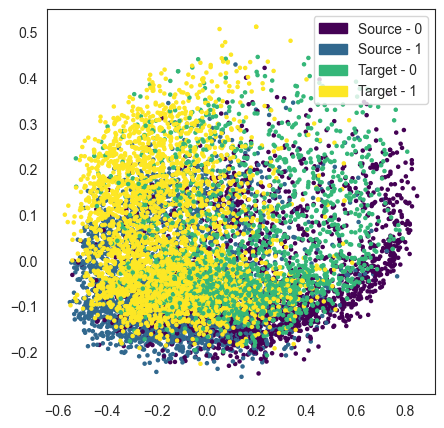

In [29]:
sns.set_style("white")


fig, ax = plt.subplots(1, 1, figsize=(5, 5))

x = PCA(n_components=2).fit_transform(np.concatenate((x_train_source, x_train_target)))
labels = ['Source - 0', 'Source - 1', 'Target - 0', 'Target - 1']
colors = [1, 2, 3, 4]
norm = Normalize(vmin=min(colors), vmax=max(colors))
ax.scatter(x[:, 0], x[:, 1], c=np.concatenate((y_train_source+1, y_train_target+3)), s=5, cmap='viridis')



legend_elements = [Patch(color=to_rgba(plt.get_cmap('viridis')(norm(i+1))), label=labels[i]) for i in range(len(labels))]
plt.legend(handles=legend_elements)

In [30]:
embed_dim = x_train_source.shape[1]
pca = PCA(n_components=embed_dim).fit(np.concatenate((x_train_source, x_train_target)))

threshold = 0.7
cumsum = 0.0
for i, eig in enumerate(pca.explained_variance_ratio_):
    cumsum += eig
    if cumsum >= threshold:
        n_components = i + 1
        print(f"{cumsum} variance explained by {n_components}/{embed_dim} components.")
        break

x_train_source = pca.transform(x_train_source)[:, 0:n_components]
x_train_target = pca.transform(x_train_target)[:, 0:n_components]
x_test_source = pca.transform(x_test_source)[:, 0:n_components]
x_test_target = pca.transform(x_test_target)[:, 0:n_components]


0.7040018066763878 variance explained by 16/768 components.


In [31]:
dataset = "amazon_data"
os.makedirs(f"./data/{dataset}", exist_ok=True)

np.save(f"./data/{dataset}/x_train_source.npy", x_train_source)
np.save(f"./data/{dataset}/y_train_source.npy", y_train_source)

np.save(f"./data/{dataset}/x_train_target.npy", x_train_target)
np.save(f"./data/{dataset}/y_train_target.npy", y_train_target)

np.save(f"./data/{dataset}/x_test_source.npy", x_test_source)
np.save(f"./data/{dataset}/y_test_source.npy", y_test_source)

np.save(f"./data/{dataset}/x_test_target.npy", x_test_target)
np.save(f"./data/{dataset}/y_test_target.npy", y_test_target)